In [59]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [40]:
df = pd.read_excel('dataset_full_after_preprocessing.xlsx', header = 1, index_col= 'Unnamed: 0')
df = df[df['kobs']!=0].drop(['element'], axis = 1)

In [91]:
#датасет, где содержатся только уникальные последовательности ДНКзимов
df_1 = df.drop_duplicates(subset = ['Sequence'])
print('Количиство уникальных строчек: ', df_1.shape[0])
#датасет, расширенный за счет добавления данных с графиков только для нескольких ДНКзимов
df_2 = df.drop_duplicates(subset = ['Sequence', 'kobs'])
print('Количество строк в расширенном датасете с добавлением данных с графиков: ', df_2.shape[0])

Количиство уникальных строчек:  128
Количество строк в расширенном датасете с добавлением данных с графиков:  151


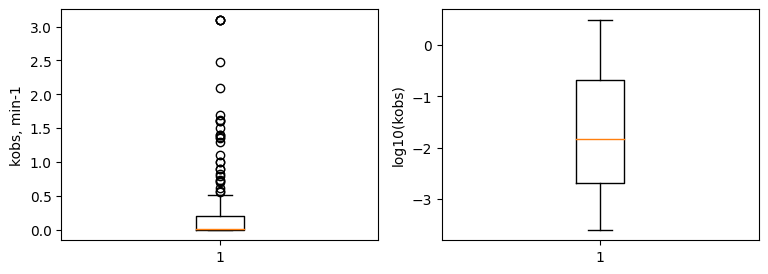

In [42]:
#произведем логарифмирование целевой переменной, чтобы сгладить разброс по порядкам и скорректировать распределение ближе к нормальному
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
axs[0].boxplot(df['kobs'].values)
axs[0].set_ylabel('kobs, min-1')
axs[1].boxplot(np.log10(df['kobs'].values))
axs[1].set_ylabel('log10(kobs)')
plt.show()

In [83]:
#Разделим выборку на обучающую и тестовую
y = np.log10(df_1['kobs'])
X = df_1.loc[:, 'Histidine':]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train.to_numpy())
X_test_scaled = scaler.transform(X_test.to_numpy())
X_train = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X.columns)


In [55]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [103]:
#видим, что сейчас алгоритм предсказывает величину активности по большей части исходя из характеристик раствора, в котором проводились измерения
from xgboost import XGBRegressor
from sklearn.feature_selection import SequentialFeatureSelector
regr = XGBRegressor()
sfs = SequentialFeatureSelector(estimator=regr, scoring="r2", n_features_to_select=20).fit(X_train, y_train)
names = np.array(X_train.columns)
sel_features = names[sfs.get_support()].tolist()
print(sel_features)

['NaCl', 'pH', 'CaCl2', 'Hg2+', 'ZnCl2', 'sodium cacodylate', 'alcohol', 'Co(NH3)6Cl3', 'Spermine', 'CdCl2', 'Lu3+', 'Gd3+', 'UO22+', 'Bis-Tris', 'sodium citrate', 'Tm3+', 'is_transition_metal', 'is_metal', 'NumAliphaticHeterocycles', 'tpsa']


r2_test: 0.5431612799631234
MAE_test: 0.41344823478763676
MSE_test: 0.41115933883520217
RMSE_test: 0.6412170762192801
r2_train: 0.9999990833189443
MAE_train: 0.0007274097111347305
MSE_train: 1.1026827028399829e-06
RMSE_train: 0.0010500869977482737


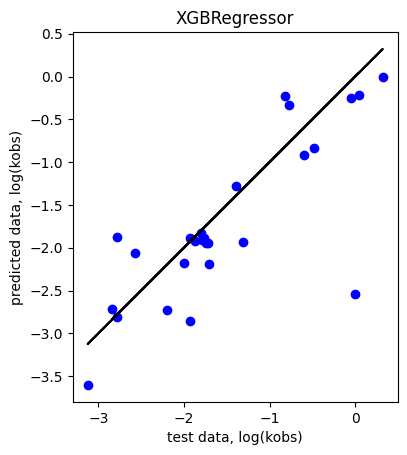

In [84]:
#Построим лучшую модель по скринингу на наших данных до добавления данных с графиков

xgb = XGBRegressor()
xgb = xgb.fit(X_train, y_train)

y1_pred_xgb = xgb.predict(X_train)
y_pred_xgb = xgb.predict(X_test)

from sklearn import metrics
print('r2_test:', metrics.r2_score(y_test, y_pred_xgb))
print('MAE_test:', metrics.mean_absolute_error(y_test, y_pred_xgb))
print('MSE_test:', metrics.mean_squared_error(y_test, y_pred_xgb))
print('RMSE_test:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_xgb)))
print('r2_train:', metrics.r2_score(y_train, y1_pred_xgb))
print('MAE_train:', metrics.mean_absolute_error(y_train, y1_pred_xgb))
print('MSE_train:', metrics.mean_squared_error(y_train, y1_pred_xgb))
print('RMSE_train:', np.sqrt(metrics.mean_squared_error(y_train, y1_pred_xgb)))

plt.scatter(y_test, y_pred_xgb, color = 'blue')
plt.plot(y_test, y_test, color = 'black')
plt.title('XGBRegressor')
plt.xlabel('test data, log(kobs)')
plt.ylabel('predicted data, log(kobs)')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [85]:
#Проверим точность на кросс-валидации
from sklearn.model_selection import cross_val_score
r2_cross_valid = cross_val_score(xgb, X_train, y_train, cv=5, scoring='r2')
rmse_cross_valid = cross_val_score(xgb, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
print("5-fold cross-validation (r2):", r2_cross_valid.mean())
print("5-fold cross-validation (RMSE):", abs(rmse_cross_valid.mean()))

5-fold cross-validation (r2): 0.49767695908768417
5-fold cross-validation (RMSE): 0.7700827587887382


Проверим, увеличивает ли точность модели расширение датасета за счет добавления данных с графиков

In [100]:
#Разделим выборку на обучающую и тестовую
y = np.log10(df_2['kobs'])
X = df_2.loc[:, 'Histidine':]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train.to_numpy())
X_test_scaled = scaler.transform(X_test.to_numpy())
X_train = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X.columns)

r2_test: 0.5291076851583253
MAE_test: 0.5520692239039602
MSE_test: 0.5940996414330123
RMSE_test: 0.7707785943012508
r2_train: 0.9999982768437519
MAE_train: 0.0009307235036230015
MSE_train: 1.8771195165842152e-06
RMSE_train: 0.001370080113199303


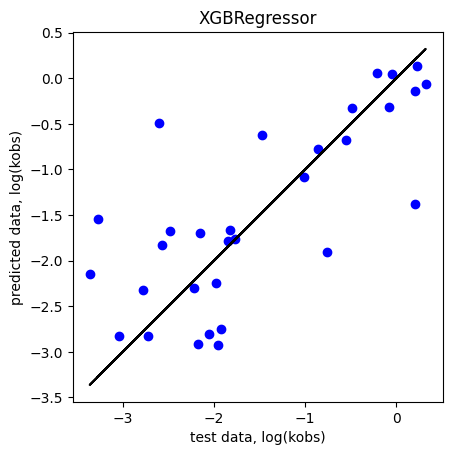

In [101]:
from xgboost import XGBRegressor
xgb = XGBRegressor()
xgb = xgb.fit(X_train, y_train)

y1_pred_xgb = xgb.predict(X_train)
y_pred_xgb = xgb.predict(X_test)

from sklearn import metrics
print('r2_test:', metrics.r2_score(y_test, y_pred_xgb))
print('MAE_test:', metrics.mean_absolute_error(y_test, y_pred_xgb))
print('MSE_test:', metrics.mean_squared_error(y_test, y_pred_xgb))
print('RMSE_test:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_xgb)))
print('r2_train:', metrics.r2_score(y_train, y1_pred_xgb))
print('MAE_train:', metrics.mean_absolute_error(y_train, y1_pred_xgb))
print('MSE_train:', metrics.mean_squared_error(y_train, y1_pred_xgb))
print('RMSE_train:', np.sqrt(metrics.mean_squared_error(y_train, y1_pred_xgb)))

plt.scatter(y_test, y_pred_xgb, color = 'blue')
plt.plot(y_test, y_test, color = 'black')
plt.title('XGBRegressor')
plt.xlabel('test data, log(kobs)')
plt.ylabel('predicted data, log(kobs)')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [102]:
#Проверим точность на кросс-валидации
from sklearn.model_selection import cross_val_score
r2_cross_valid = cross_val_score(xgb, X_train, y_train, cv=5, scoring='r2')
rmse_cross_valid = cross_val_score(xgb, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
print("5-fold cross-validation (r2):", r2_cross_valid.mean())
print("5-fold cross-validation (RMSE):", abs(rmse_cross_valid.mean()))

5-fold cross-validation (r2): 0.4963376658101445
5-fold cross-validation (RMSE): 0.7135922305916509


Видим, что расширение датасета на 15% не привело к улудшению метрик для алгоритма градиентного бустинга, также видим большую склонность алгоритма к переобучению